In [1]:
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.ndimage import gaussian_filter
from importlib import reload
import datetime as dt
sys.path.append(r'D:\07. Software\jupyter')
# sys.path.append(r'D:\My Drive go.ugr.es\07. Software\jupyter')
from utils_gfat import lidar, plot, aeronet, lidarQA, ecmwf
from utils_gfat import lidar_elastic_retrieval
import lidar_processing.lidar_processing.helper_functions as helper_functions
import pdb

In [2]:
#Define date
datestr = '20210709'
date_ = dt.datetime.strptime(datestr, '%Y%m%d')
year, month, day = date_.year, date_.month, date_.day
ymin_referece = 7000
ymax_referece = 8000
ymax = 9000
resolution_time = 10
resolution_range = 7.5 
profile_time = np.arange(date_,date_+dt.timedelta(days=1)+dt.timedelta(minutes=resolution_time),dt.timedelta(minutes=resolution_time))

In [3]:
#Load data
#LIDAR
rs_fl = os.path.join(r'Y:\datos\MULHACEN\1a\%d\%02d\%02d' % (year, month, day), 'mhc_1a_Prs_%s.nc' % datestr)  
dc_fl = os.path.join(r'Y:\datos\MULHACEN\1a\%d\%02d\%02d' % (year, month, day), 'mhc_1a_Pdc_%s_*.nc' % datestr)  
lr_fl = os.path.join(r'D:\07. Software\jupyter\SPIE - AERONET', 'lr_%s.nc' % datestr)  
ecmwf_fl = os.path.join(r'Y:\datos\ECMWF\%s' % year, '%s_granada_ecmwf.nc' % datestr)
outputdir = r'C:\Users\Usuario\Downloads'

   
#ECMWF
ecmwf_ds = ecmwf.reader(ecmwf_fl)

#LIDAR RATIO
LR={355: [], 532: [], 1064:[]}
lr_ds = xr.open_dataset(lr_fl)
LR[355] = lr_ds['LR355'].interp(time=profile_time)
LR[532] = lr_ds['LR532'].interp(time=profile_time)
LR[1064]= lr_ds['LR1064'].interp(time=profile_time)   

In [4]:
channel_dict={355: [4], 532: [0,2], 1064:[6]}
rcs_dict={355: 'corrected_rcs_04', 532: 'total_rcs532_an', 1064:'corrected_rcs_06'}

klett_sm = {355:  np.nan*np.ones((len(profile_time), int(ymax/resolution_range))),
         532:  np.nan*np.ones((len(profile_time), int(ymax/resolution_range))),
         1064: np.nan*np.ones((len(profile_time), int(ymax/resolution_range)))}
attbeta_total_rcs_sm = {355:  np.nan*np.ones((len(profile_time), int(ymax/resolution_range))),
         532:  np.nan*np.ones((len(profile_time), int(ymax/resolution_range))),
         1064: np.nan*np.ones((len(profile_time), int(ymax/resolution_range)))}
attbeta_total_klett_sm = {355:  np.nan*np.ones((len(profile_time), int(ymax/resolution_range))),
         532:  np.nan*np.ones((len(profile_time), int(ymax/resolution_range))),
         1064: np.nan*np.ones((len(profile_time), int(ymax/resolution_range)))}
calib_profile_sm = {355:  np.nan*np.ones((len(profile_time), int(ymax/resolution_range))),
         532:  np.nan*np.ones((len(profile_time), int(ymax/resolution_range))),
         1064: np.nan*np.ones((len(profile_time), int(ymax/resolution_range)))}
calib_sm = {355: np.nan*np.ones(len(profile_time)), 532: np.nan*np.ones(len(profile_time)), 1064: np.nan*np.ones(len(profile_time))}

for idx, time_ in enumerate(profile_time):
    print('%d: %s' % (idx, time_))
    time_ini = time_.astype(dt.datetime)
    time_ini_str = dt.datetime.strftime(time_ini,'%Y%m%dT%H%M%S')
    time_end = time_ini + dt.timedelta(minutes=resolution_time)
    time_end_str = dt.datetime.strftime(time_end,'%Y%m%dT%H%M%S')    
    for wavelength in [355, 532, 1064]:   
        go = True
#         lr_ = LR[wavelength][idx].values
#         if np.isnan(lr_):
        lr_ = LR[wavelength].mean().values        
        channels_ = channel_dict[wavelength]
        rcs_name = rcs_dict[wavelength]

        try:
            #Lidar signal            
            wds = lidar.preprocessing(rs_fl, dc_fl, channels=channels_, 
                                      deadtime_flag=False, 
                                      zerobin_flag=False,
                                      ini_date=time_ini_str, 
                                      end_date=time_end_str,
                                      percentage_required=50,
                                      end_range=ymax)            
            wds['%s_sm' % rcs_name] = (('time','range'), gaussian_filter(wds[rcs_name].values,sigma=5))
#             print('lidar %d processed' % wavelength)            
            height = wds['range'].values
            resolution = np.median(np.diff(height))
            idx_min = np.abs(np.diff(height-ymin_referece)).argmin()
            idx_max = np.abs(np.diff(height-ymax_referece)).argmin()
        except:            
            go = False

        if go and wds is not None:
            try:
                ecmwf_ds = ecmwf.reader(ecmwf_fl)
            except:                
                go = False
    
            if go:
#                 print('go is %s' % go)
                #ECMWF
                pressure_prf, temperature_prf = ecmwf.level2height(ecmwf_ds.sel(time=time_ini_str, method='nearest'), height)
                molecular_profiles = lidarQA.molecular_properties(wavelength, pressure_prf, temperature_prf, height, component='cabannes')            
                beta_mol = molecular_profiles['molecular_beta'].values
                lr_mol = molecular_profiles['molecular_lidar_ratio'].values           

                for smooth in [True, False]:       
#                     print('smooth is %s' % smooth)

                    # RCS
                    if smooth:
                        rcs = wds['%s_sm' % rcs_name].sel(range=slice(0,ymax)).mean('time')      
                    else:
                        rcs = wds[rcs_name].sel(range=slice(0,ymax)).mean('time')      
                        
                    try:
                        klett_ = lidar_elastic_retrieval.klett(rcs.values, height, 
                                                                      beta_mol, lr_mol, lr_aer = lr_, 
                                                                      ymin = ymin_referece, ymax = ymax_referece)                                                                                        
                        aod_total_ = integrate.cumtrapz(klett_*lr_+beta_mol*lr_mol, dx=resolution, initial=0)                    
                        calib_profile_ = (rcs/(klett_+beta_mol))*np.exp(2*aod_total_)
                        calib_value_ = calib_profile_.sel(range=slice(ymin_referece,ymax_referece)).mean().values
                        attbeta_klett_ = (klett_+beta_mol)*np.exp(-2*aod_total_)
                        attbeta_rcs_ = rcs.values/calib_value_ 
                        
                        quasi_,converged_,_ = lidar_elastic_retrieval.quasi_backscatter_aerosol(attbeta_rcs_, height, beta_mol, lr_mol, lr_aer = lr_, debugging=False)
#                         print('Retrievals at %d done' % wavelength)
                    except:
                        pdb.set_trace()                

                    calib_profile_sm[wavelength][idx,:] = calib_profile_
                    klett_sm[wavelength][idx,:] = klett_
                    quasi_sm[wavelength][idx,:] = quasi_
                    calib_sm[wavelength][idx] = calib_value_
                    attbeta_total_rcs_sm[wavelength][idx,:] = attbeta_rcs_
                    attbeta_total_klett_sm[wavelength][idx,:] = attbeta_klett_
            else:
                pdb.set_trace()

klett355s = xr.DataArray(klett_sm[355], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
klett532s = xr.DataArray(klett_sm[532], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
klett1064s = xr.DataArray(klett_sm[1064], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
quasi355s = xr.DataArray(quasi_sm[355], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
quasi532s = xr.DataArray(quasi_sm[532], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
quasi1064s = xr.DataArray(quasi_sm[1064], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
abtr355s = xr.DataArray(attbeta_total_rcs_sm[355], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
abtr532s = xr.DataArray(attbeta_total_rcs_sm[532], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
abtr1064s = xr.DataArray(attbeta_total_rcs_sm[1064], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
abtk355s = xr.DataArray(attbeta_total_klett_sm[355], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
abtk532s = xr.DataArray(attbeta_total_klett_sm[532], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
abtk1064s = xr.DataArray(attbeta_total_klett_sm[1064], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
calib_profile_355s = xr.DataArray(calib_profile_sm[355], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
calib_profile_532s = xr.DataArray(calib_profile_sm[532], dims=['time', 'range'], coords={'time': profile_time, 'range': height})
calib_profile_1064s = xr.DataArray(calib_profile_sm[1064], dims=['time', 'range'], coords={'time': profile_time, 'range': height})

calib355s = xr.DataArray(calib_sm[355], dims=['time'], coords={'time': profile_time})
calib532s = xr.DataArray(calib_sm[532], dims=['time'], coords={'time': profile_time})
calib1064s = xr.DataArray(calib_sm[1064], dims=['time'], coords={'time': profile_time})

klett_xr = xr.Dataset({'klett355sm': klett355s, 'klett532sm': klett532s, 'klett1064sm': klett1064s, 
                       'quasi355sm': quasi355s, 'quasi532sm': quasi532s, 'quasi1064sm': quasi1064s, 
                       'calib355sm': calib355s, 'calib532sm': calib532s, 'calib1064sm': calib1064s, 
                       'attbeta_total_rcs355sm': abtr355s, 'attbeta_total_rcs532sm': abtr532s,
                       'attbeta_total_rcs1064sm': abtr1064s,
                       'attbeta_total_klett355sm': abtk355s, 'attbeta_total_klett532sm': abtk532s,
                       'attbeta_total_klett1064sm': abtk1064s,
                       'calib_profile355sm': calib_profile_355s, 'calib_profile532sm': calib_profile_532s,
                       'calib_profile1064sm': calib_profile_1064s})
klett_xr.to_netcdf(os.path.join(outputdir, 'smooth_klett_calib_attbeta_%dmin_%s_%d-%d.nc' % (resolution_time, datestr, ymin_referece, ymax_referece)))

0: 2021-07-09T00:00:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T000000 to 20210709T001000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T000000 to 20210709T001000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T000000 to 20210709T001000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
1: 2021-07-09T00:10:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T001000 to 20210709T002000
['Y:\\datos\\MULHACEN

10: 2021-07-09T01:40:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T014000 to 20210709T015000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T014000 to 20210709T015000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T014000 to 20210709T015000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
11: 2021-07-09T01:50:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T015000 to 20210709T020000
['Y:\\datos\\MULHAC

20: 2021-07-09T03:20:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T032000 to 20210709T033000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T032000 to 20210709T033000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T032000 to 20210709T033000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
21: 2021-07-09T03:30:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T033000 to 20210709T034000
['Y:\\datos\\MULHAC

30: 2021-07-09T05:00:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T050000 to 20210709T051000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T050000 to 20210709T051000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T050000 to 20210709T051000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
31: 2021-07-09T05:10:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T051000 to 20210709T052000
['Y:\\datos\\MULHAC

INFO: Data loaded from 20210709T064000 to 20210709T065000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T064000 to 20210709T065000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T064000 to 20210709T065000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
41: 2021-07-09T06:50:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T065000 to 20210709T070000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1

INFO: Data loaded from 20210709T082000 to 20210709T083000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T082000 to 20210709T083000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T082000 to 20210709T083000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
51: 2021-07-09T08:30:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T083000 to 20210709T084000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1

['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T100000 to 20210709T101000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T100000 to 20210709T101000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
61: 2021-07-09T10:10:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T101000 to 20210709T102000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\

['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T114000 to 20210709T115000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T114000 to 20210709T115000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
71: 2021-07-09T11:50:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T115000 to 20210709T120000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\

INFO: Data loaded from 20210709T132000 to 20210709T133000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T132000 to 20210709T133000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T132000 to 20210709T133000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
81: 2021-07-09T13:30:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T133000 to 20210709T134000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1

['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T150000 to 20210709T151000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T150000 to 20210709T151000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
91: 2021-07-09T15:10:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T151000 to 20210709T152000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\

INFO: Data loaded from 20210709T164000 to 20210709T165000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T164000 to 20210709T165000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T164000 to 20210709T165000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
101: 2021-07-09T16:50:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T165000 to 20210709T170000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_

['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T182000 to 20210709T183000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T182000 to 20210709T183000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
111: 2021-07-09T18:30:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T183000 to 20210709T184000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\

['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T200000 to 20210709T201000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T200000 to 20210709T201000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
121: 2021-07-09T20:10:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T201000 to 20210709T202000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\

INFO: Data loaded from 20210709T214000 to 20210709T215000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T214000 to 20210709T215000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T214000 to 20210709T215000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_1817.nc']
131: 2021-07-09T21:50:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
INFO: Data loaded from 20210709T215000 to 20210709T220000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Pdc_20210709_0641.nc', 'Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_

['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
ERROR. Preprocessing not performed for File(s) Y:\datos\MULHACEN\1a\2021\07\09\mhc_1a_Prs_20210709.nc
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
ERROR. Preprocessing not performed for File(s) Y:\datos\MULHACEN\1a\2021\07\09\mhc_1a_Prs_20210709.nc
141: 2021-07-09T23:30:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
ERROR. Preprocessing not performed for File(s) Y:\datos\MULHACEN\1a\2021\07\09\mhc_1a_Prs_20210709.nc
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
ERROR. Preprocessing not performed for File(s) Y:\datos\MULHACEN\1a\2021\07\09\mhc_1a_Prs_20210709.nc
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
ERROR. Preprocessing not performed for File(s) Y:\datos\MULHACEN\1a\2021\07\09\mhc_1a_Prs_20210709.nc
142: 2021-07-09T23:40:00.000000
['Y:\\datos\\MULHACEN\\1a\\2021\\07\\09\\mhc_1a_Prs_20210709.nc']
ERROR. Preprocessing not perfo

In [4]:
klett_xr = xr.open_dataset(os.path.join(outputdir, 'smooth_klett_calib_attbeta_%dmin_%s_%d-%d.nc' % (resolution_time, datestr, ymin_referece, ymax_referece)))              

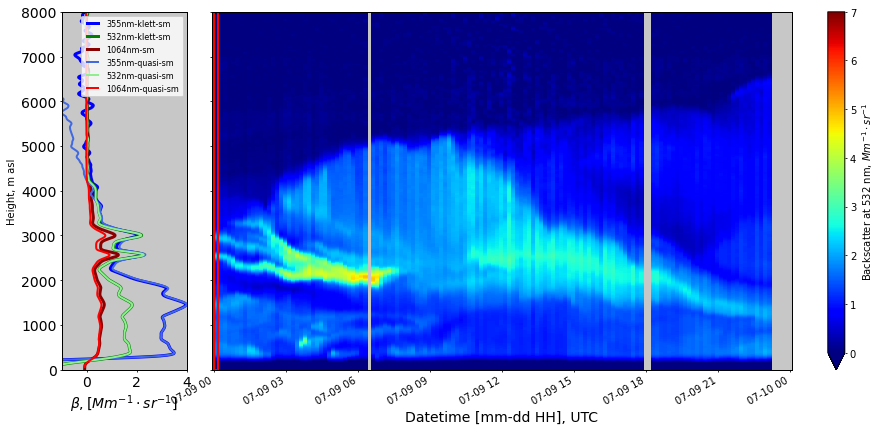

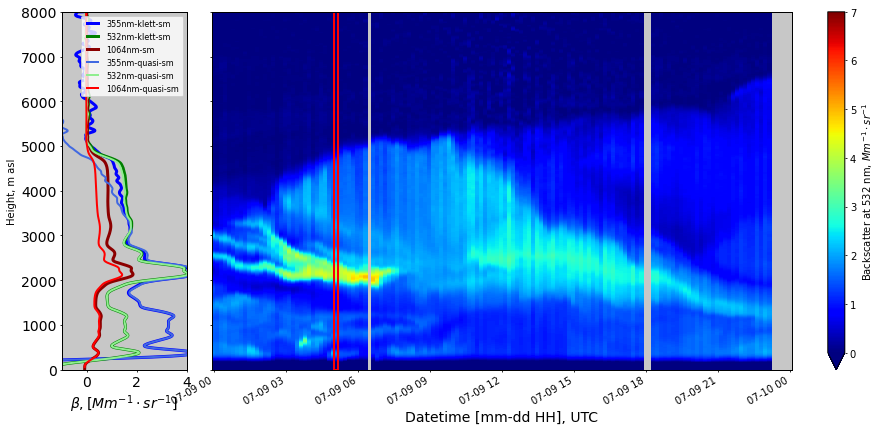

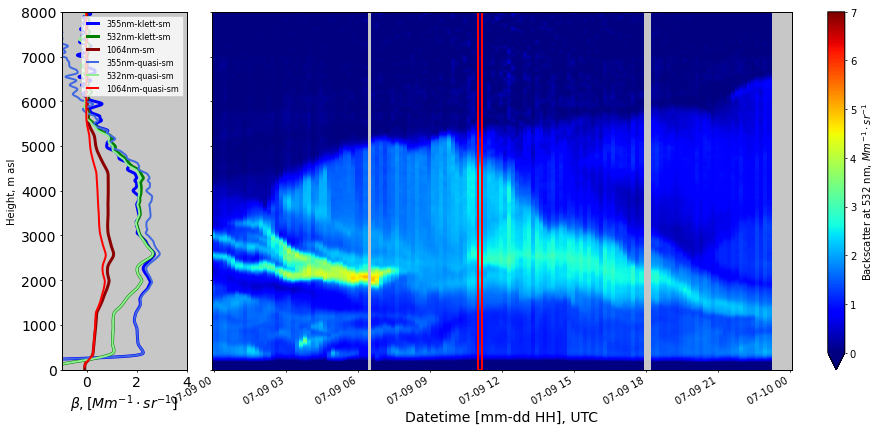

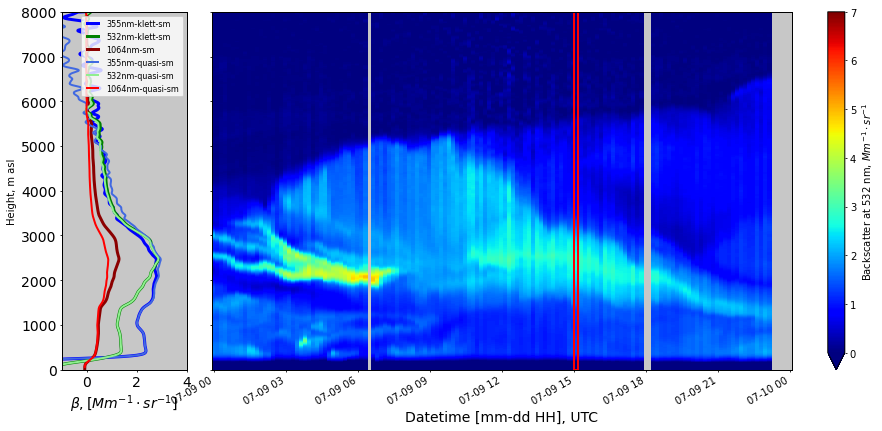

In [15]:
for profile_time_ini in ['20210709T000000', '20210709T050000', '20210709T110000', '20210709T150000']:
    quicklook_wavelength = 532
    fig, ax = plt.subplots(figsize=[15,7])
    ax1 = plt.subplot(1,6,(1))
    ax1.plot((klett355s*1e6).sel(time=profile_time_ini, method='nearest').values, height, lw=3, c='b', label='355nm-klett-sm')
    ax1.plot((klett532s*1e6).sel(time=profile_time_ini, method='nearest').values, height, lw=3, c='g', label='532nm-klett-sm')
    ax1.plot((klett1064s*1e6).sel(time=profile_time_ini, method='nearest').values, height, lw=3, c='darkred', label='1064nm-sm')
    ax1.plot((quasi355s*1e6).sel(time=profile_time_ini, method='nearest').values, height, lw=2, c='royalblue', label='355nm-quasi-sm')
    ax1.plot((quasi532s*1e6).sel(time=profile_time_ini, method='nearest').values, height, lw=2, c='lightgreen', label='532nm-quasi-sm')
    ax1.plot((quasi1064s*1e6).sel(time=profile_time_ini, method='nearest').values, height, lw=2, c='r', label='1064nm-quasi-sm')

    ax2 = plt.subplot(1,6,(2,6), sharey=ax1)
    (klett532s*1e6).plot(y='range',vmin=0,vmax=7, cmap='jet', ax=ax2, cbar_kwargs={"label": "Backscatter at 532 nm, $Mm^{-1}\cdot sr^{-1}$"})

    #Set properties
    ax1.legend(fontsize=8)
    ax1.set_ylim(0,8000)
    ax1.set_xlim(-1,4)
    o_ = plt.setp((ax1.get_yticklabels(), ax1.get_xticklabels()), fontsize=14)
    ax1.set_xlabel('$\\beta, [Mm^{-1}\cdot sr^{-1}]$', fontsize=14)
    o_ = plt.setp(ax2.get_yticklabels(), visible=False)
    ax1.set_ylabel('Height, m asl')
    ax2.set_xlabel('Datetime [mm-dd HH], UTC', fontsize=14)
    ax2.set_ylabel('')

    # Create rectangle x coordinates
    startTime = dt.datetime.strptime(profile_time_ini,'%Y%m%dT%H%M%S')
    endTime = dt.datetime.strptime(profile_time_ini,'%Y%m%dT%H%M%S') + dt.timedelta(minutes=resolution_time)

    # convert to matplotlib date representation
    start = mpl.dates.date2num(startTime)
    end = mpl.dates.date2num(endTime)
    width = end - start

    # Plot rectangle
    rect = mpl.patches.Rectangle((start, 0), width, 8000, linewidth=2,color='red',fill=False)
    ax2.add_patch(rect)


    fig.savefig(os.path.join(outputdir, 'beta%d_%s_%dmin_%02d%02d-%02d%02d.png' % (quicklook_wavelength, datestr, resolution_time, startTime.hour, startTime.minute, endTime.hour, endTime.minute)))